# Recommender System Mini-Project

We were developing a recommender system for a music service, that brings more relevant items to the users. This notebook follows the following structure
* Introduction: Data Set and Business Objective
* Sampling and Preprocessing Data
* Validation and Testing Set-up
* Neighborhood Collaborative Filtering
* Latent Factors Model
* Summary and Conclusion


In [46]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from models.model_based import matrix_creation
from models.cross_validation import ModelTester
from models.model_based import matrix_factorization_model
from models.cross_validation import loss_functions as lf



IndentationError: unexpected indent (loss_functions.py, line 7)

In [47]:
%matplotlib inline

## Introduction: Data Set and Business Objective

Our data set is obtained from Deezer, a French music streaming service. The variables of interest are user_id and media_id (which indicates a song that has been listened to). 

Our objective is to improve the recommendation for a user. Improvements we define as to be a more accurate rating, which is that a user is more likely to listen to the suggested song than to skip it. 

In [2]:
path = '../data/train.csv'
data = pd.read_csv(path)

Our approach is to build two models. One neighborhood collaborative filtering recommendation and a latent factor model based approach. For the latent factor model we used 2 different models: one pre-build package that implemets SVD++ and a own-developed latent factor model that introduces bias for data missing not at random. 

---

## Sampling Data and Preprocessing

The raw data has about 19,918 unique users and 452,975 unique media items. For our recommender system we reduced the matrix to include less than 10,000 users and about 100 items. For this we developed two sampling methods. 

First, we selected the 100 most frequently exposed items, i.e. items where data about the user-item interaction is available. We then selected all users, where we had more than 10 user-item interactions avaiable. An advantage of this approach is, that we achieve a high fill rate of the resulting rating matrix, however, by only concentrating on popular items, we might loose out on serendipity of items and might ignore any bias in the most frequently exposed items (that they are from one specific genre e.g. pop). 

That's why we also used a second sampling approach, where we selected the 50 most frequently exposed items, and randomly sampeled 50 items from the following 10,000 most frequently ratings. We then also included every user that had more than 10 user-item interactions into the rating matrix. While we obtain a lower fill rate, it is still high enough to train the recommendation sytem, but increase diversity of the items in the system. 

In [3]:
# The number of unique users and items in the raw data
data['user_id'].nunique(),data['media_id'].nunique()

(19918, 452975)

In [4]:
# Plot different sampling stratgies => number of ratings per item (short, longtail)

The raw data includes a time period of one month. Therefor a user might have encountered an item several times. For measuring user-item interaction we used two measures. First, we used the mean of the number of times a user has listened to a song when they encountered it (Hit-Rate). Second, we used the median of the number of times a user has listened to a song when they encountered it, to obtain a binary indication whether a user likes a song or not. For clarity reasons, we just present the hit-rate matrix in the following sections.

In [5]:
ratings = matrix_creation.hit_rate_matrix_popular_items(data)
ratings2 = matrix_creation.hit_rate_matrix_50_50(data)

In [6]:
# Shape of the rating matrix with 100 most encountered items
# Fill rate of the matrix with the 100 most encountered items
print(ratings.shape)
print(ratings.count().sum()/float((ratings.shape[0]*ratings.shape[1])))

(8644, 100)
0.271092086997


In [7]:
# Shape of the rating matrix with 50 most encountered items and 50 randomly sampled
# Fill rate of the 50/50 matrix
print(ratings2.shape)
print(ratings2.count().sum()/float((ratings2.shape[0]*ratings2.shape[1])))

(6024, 100)
0.204737715803


---

## Validation and Testing Set-up

To test the accuracy of our model, we used the standart train, validation, test set-up. First, we set aside a test-set of the data in the matrix, that is only used for the final testing. Second, we split the remaing data in a validation set and a training set. To make the accuracy of the predictions independent from the validation-training-split, we would use cross-validation. Which is we would use several validation-training splits at random and take the mean of the accuracy metric as result. 

Creating the test, validation and training split will be done by class ModelTester

In [8]:
cross_validation = ModelTester.ModelTester()

In [9]:
cross_validation.fit_transform(ratings2)

>>> The cross-validation framework is being built ...
    Please wait, you'll be able to use all of its features soon!
>>> DONE


To test our model against a baseline, we use three measures:
- Assining a hit rate of 1 to every user-item pair
- Assinging the mean hit-rate to every user-item pair
- Assining a random hit-rate to every user-item pair

For these baselines we get the following test metrics


In [29]:
# Assining a hit rate of 1 to every user-item pair
baseline = pd.DataFrame(np.ones(ratings2.shape))
baseline.columns = ratings2.columns
baseline.index = ratings2.index
cross_validation.evaluate_valid(baseline,loss_func=lf.mean_squared_error)
cross_validation.evaluate_valid(baseline,loss_func=lf.absolute_mean_error)


MSE: 0.364871778748
AME: 0.416447144099


0.4164471440994223

In [30]:
# Assinging the mean hit-rate to every user-item pair
baseline = pd.DataFrame(np.ones(ratings2.shape))*ratings2.mean().mean()
baseline.columns = ratings2.columns
baseline.index = ratings2.index
cross_validation.evaluate_valid(baseline,loss_func=lf.mean_squared_error)
cross_validation.evaluate_valid(baseline,loss_func=lf.absolute_mean_error)


MSE: 0.191535991956
AME: 0.403972394868


0.4039723948684249

In [31]:
# Assining a random hit-rate to every user-item pair
baseline = pd.DataFrame(np.random.rand(*ratings2.shape))
baseline.columns = ratings2.columns
baseline.index = ratings2.index
cross_validation.evaluate_valid(baseline,loss_func=lf.mean_squared_error)
cross_validation.evaluate_valid(baseline,loss_func=lf.absolute_mean_error)

MSE: 0.283243084986
AME: 0.449503257352


0.44950325735191887

---

## Neighborhood Colloaborative Filtering

---

## Latent Factor Model 

For the model-based approach we chose a latent factor model with a bias term for missing data. We assume that the values in the rating matrix is not missing at random and thus introduce a bias term for missing data and weights.

This section is structured in the following way
* Define the latent factor model
* Hyperparameter Tuning
* Scaling
* Final Test

#### Model Definition

In [10]:
# SVD with bias and regularization
%time 
predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                            latent_factors=5, 
                                                            bias=0.2, 
                                                            bias_weights=1, 
                                                            regularization=100,
                                                            learning_rate=0.0001, 
                                                            convergence_rate =0.99999
                                                            )

CPU times: user 16 µs, sys: 10 µs, total: 26 µs
Wall time: 41 µs


In [10]:
# SVD++ from package

#### Hyperparameter Tuning

In this section we explore the hyper-parameters of the model and test is with respect to the crossvalidation set. The following hyperparameters need to be chosen: 
* No of latent factors
* Regularization term
* Bias 
* Bias weights

Tuning will take place in two rounds. In the first round we will explore the parameter space, to get an idea about where the best parameters lie. The second round will be informed by this exploration and further tune the parameters to find the best performing model. 

##### First Round 


In [40]:
regularization= [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 50, 100, 500, 1000]
regularization_mse = []
regularization_ame = []
for r in regularization:
    predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                            latent_factors=5, 
                                                            bias=0.5, 
                                                            bias_weights=0.25, 
                                                            regularization=r,
                                                            learning_rate=0.0001, 
                                                            convergence_rate =0.99999
                                                            )
    predictions = pd.DataFrame(predictions)
    predictions.columns = ratings2.columns
    predictions.index = ratings2.index
    print('Regularization-Parameter: '+ str(r))
    ame = cross_validation.evaluate_valid(predictions,loss_func=lf.absolute_mean_error)
    mse = cross_validation.evaluate_valid(predictions,loss_func=lf.mean_squared_error)
    regularization_mse.append(mse)
    regularization_ame.append(ame)


Regularization-Parameter: 0.01
AME: 0.350701633728
MSE: 0.149833001097
Regularization-Parameter: 0.05
AME: 0.350285288509
MSE: 0.14956475686
Regularization-Parameter: 0.1
AME: 0.350561343506
MSE: 0.149691940006
Regularization-Parameter: 0.5
AME: 0.34946366432
MSE: 0.149072669499
Regularization-Parameter: 1
AME: 0.33279826554
MSE: 0.145603598354
Regularization-Parameter: 5
AME: 0.350849043074
MSE: 0.149466793769
Regularization-Parameter: 10
AME: 0.35440353723
MSE: 0.151394076155
Regularization-Parameter: 50
AME: 0.398375213399
MSE: 0.186415811259
Regularization-Parameter: 100
AME: 0.42886708298
MSE: 0.217569341596
Regularization-Parameter: 500
AME: 0.445236044819
MSE: 0.239480227828
Regularization-Parameter: 1000
AME: 0.465412282958
MSE: 0.266118270888


In [41]:
latent_factors = [1,2,3,4,5,6,7,10,12,15,17,20,30,40,50]
latent_factors_mse = []
latent_factors_ame = []
for l in latent_factors:
    print('Number of Latent Factors: '+ str(l))
    predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                            latent_factors=l, 
                                                            bias=0.5, 
                                                            bias_weights=0.25, 
                                                            regularization=0.5,
                                                            learning_rate=0.0001, 
                                                            convergence_rate =0.1
                                                            )
    predictions = pd.DataFrame(predictions)
    predictions.columns = ratings2.columns
    predictions.index = ratings2.index
    ame = cross_validation.evaluate_valid(predictions,loss_func=lf.absolute_mean_error)
    mse = cross_validation.evaluate_valid(predictions,loss_func=lf.mean_squared_error)
    latent_factors_mse.append(mse)
    latent_factors_ame.append(ame)

Number of Latent Factors: 1
AME: 0.492493117357
MSE: 0.328946203929
Number of Latent Factors: 2
AME: 0.441928009844
MSE: 0.263383577122
Number of Latent Factors: 3
AME: 0.447998247904
MSE: 0.282985962414
Number of Latent Factors: 4
AME: 0.457846539577
MSE: 0.316598299503
Number of Latent Factors: 5
AME: 0.461985322169
MSE: 0.332548936924
Number of Latent Factors: 6
AME: 0.469579887248
MSE: 0.344993376479
Number of Latent Factors: 7
AME: 0.464066576272
MSE: 0.338366743545
Number of Latent Factors: 10
AME: 0.446639988407
MSE: 0.295321440078
Number of Latent Factors: 12
AME: 0.440517487473
MSE: 0.265779219076
Number of Latent Factors: 15
AME: 0.452897014292
MSE: 0.284925323537
Number of Latent Factors: 17
AME: 0.466329315849
MSE: 0.307077897229
Number of Latent Factors: 20
AME: 0.782830145309
MSE: 0.989517495673
Number of Latent Factors: 30
AME: 7.61320137162
MSE: 69.8419421199
Number of Latent Factors: 40
AME: 24.1213897581
MSE: 666.592686489
Number of Latent Factors: 50
AME: 50.88329887

In [42]:
# adapt latent factors and learning rate to best results from the tuning
bias = np.arange(0.0,1.05,0.1)
bias_ame = []
bias_sme = []
for b in bias:
    print('Bias: '+ str(b))
    predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                            latent_factors=6, 
                                                            bias=b, 
                                                            bias_weights=0.25, 
                                                            regularization=0.5,
                                                            learning_rate=0.0001, 
                                                            convergence_rate =0.99999
                                                            )
    predictions = pd.DataFrame(predictions)
    predictions.columns = ratings2.columns
    predictions.index = ratings2.index
    ame = cross_validation.evaluate_valid(predictions,loss_func=lf.absolute_mean_error)
    mse = cross_validation.evaluate_valid(predictions,loss_func=lf.mean_squared_error)
    bias_sme.append(mse)
    bias_ame.append(ame)

Bias: 0.0
AME: 0.324652053015
MSE: 0.185644082181
Bias: 0.1
AME: 0.364752648363
MSE: 0.194354332344
Bias: 0.2
AME: 0.354573092366
MSE: 0.176536230509
Bias: 0.3
AME: 0.347674559427
MSE: 0.163166471536
Bias: 0.4
AME: 0.335079582702
MSE: 0.151223821963
Bias: 0.5
AME: 0.328353053759
MSE: 0.144826968588
Bias: 0.6
AME: 0.345640513411
MSE: 0.149226918356
Bias: 0.7
AME: 0.345191945333
MSE: 0.154287100607
Bias: 0.8
AME: 0.344699636822
MSE: 0.16213511883
Bias: 0.9
AME: 0.314178186388
MSE: 0.163451461308
Bias: 1.0
AME: 0.348453598173
MSE: 0.188260779746


In [43]:
# adapt latent factors and learning rate to best results from the tuning
bias_weights = np.arange(0.01,1.05,0.1)
bias_weights_sme = []
bias_weights_ame = []
for b in bias_weights:
    print('Bias-weight: '+ str(b))
    predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                            latent_factors=6, 
                                                            bias=0.4, 
                                                            bias_weights=b, 
                                                            regularization=0.5,
                                                            learning_rate=0.0001, 
                                                            convergence_rate =0.99999
                                                            )
    predictions = pd.DataFrame(predictions)
    predictions.columns = ratings2.columns
    predictions.index = ratings2.index
    ame = cross_validation.evaluate_valid(predictions,loss_func=lf.absolute_mean_error)
    mse = cross_validation.evaluate_valid(predictions,loss_func=lf.mean_squared_error)
    bias_weights_sme.append(mse)
    bias_weights_ame.append(ame)

Bias-weight: 0.01
AME: 0.319165693195
MSE: 0.172574366464
Bias-weight: 0.11
AME: 0.32345983111
MSE: 0.152277650222
Bias-weight: 0.21
AME: 0.333398825399
MSE: 0.151189233529
Bias-weight: 0.31
AME: 0.342740933334
MSE: 0.153922322988
Bias-weight: 0.41
AME: 0.348726289456
MSE: 0.155365362446
Bias-weight: 0.51
AME: 0.380214453286
MSE: 0.169263745718
Bias-weight: 0.61
AME: 0.386842074422
MSE: 0.174253626625
Bias-weight: 0.71
AME: 0.391924301132
MSE: 0.178301937782
Bias-weight: 0.81
AME: 0.396106056101
MSE: 0.181701384655
Bias-weight: 0.91
AME: 0.399921426014
MSE: 0.18491033304
Bias-weight: 1.01
AME: 0.402948998772
MSE: 0.187449975429


##### First Round: Results

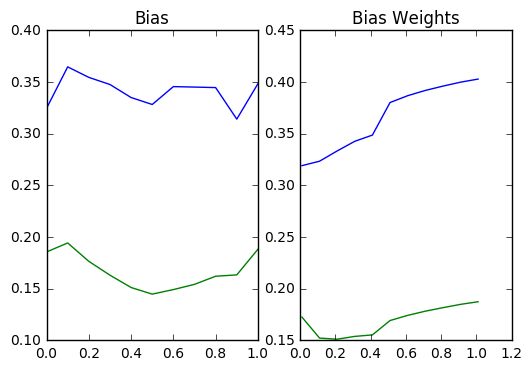

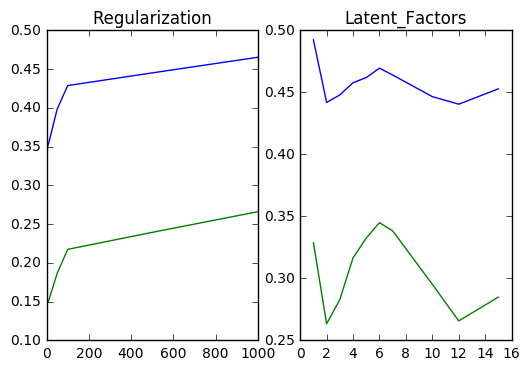

In [61]:
# plots 
plt.figure(1)
plt.subplot(1,2,1)
plt.title('Bias')
plt.plot(bias, bias_ame)
plt.plot(bias, bias_sme)
plt.subplot(1,2,2)
plt.title('Bias Weights')
plt.plot(bias_weights, bias_weights_ame)
plt.plot(bias_weights, bias_weights_sme)
plt.figure(2)
plt.subplot(1,2,1)
plt.title('Regularization')
plt.plot(regularization, regularization_ame)
plt.plot(regularization, regularization_mse)
plt.subplot(1,2,2)
plt.title('Latent_Factors')
plt.plot(latent_factors[:10], latent_factors_ame[:10])
plt.plot(latent_factors[:10], latent_factors_mse[:10])

- Result: do grid search around parameters 
* regularization: 1
* latent_factors: 2 and 12
* bias: 0.4-0.6
* bias weights: 0.15-0.25

##### Second Round - Binary Search
find interactions between hyperparameters

* Bias and bias_weights

In [65]:
bias = np.arange(0.4,0.6,0.02)
bias_weights = np.arange(0.15,0.251,0.025)
bias_and_weights_mse = np.zeros((len(bias),len(bias_weights)))
bias_and_weights_ame = np.zeros((len(bias),len(bias_weights)))
i = 0
for b in bias:
    j = 0
    for bw in bias_weights:
        print('Bias: '+ str(b))
        print('Bias-weight: '+ str(bw))
        predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                                latent_factors=12, 
                                                                bias=b, 
                                                                bias_weights=bw, 
                                                                regularization=1,
                                                                learning_rate=0.0001, 
                                                                convergence_rate =0.99999
                                                                )
        predictions = pd.DataFrame(predictions)
        predictions.columns = ratings2.columns
        predictions.index = ratings2.index
        ame = cross_validation.evaluate_valid(predictions,loss_func=lf.absolute_mean_error)
        mse = cross_validation.evaluate_valid(predictions,loss_func=lf.mean_squared_error)
        bias_and_weights_mse[i,j] = mse
        bias_and_weights_ame[i,j] = ame
        j += 1
    i += 1 

Bias: 0.4
Bias-weight: 0.15
AME: 0.346093953522
MSE: 0.169447791211
Bias: 0.4
Bias-weight: 0.175
AME: 0.346445671834
MSE: 0.167585558994
Bias: 0.4
Bias-weight: 0.2
AME: 0.348629390059
MSE: 0.167108112607
Bias: 0.4
Bias-weight: 0.225
AME: 0.349625320839
MSE: 0.166902605051
Bias: 0.42
Bias-weight: 0.15
AME: 0.346201411446
MSE: 0.169256017207
Bias: 0.42
Bias-weight: 0.175
AME: 0.346311672335
MSE: 0.167488883189
Bias: 0.42
Bias-weight: 0.2
AME: 0.348833295611
MSE: 0.167150023445
Bias: 0.42
Bias-weight: 0.225
AME: 0.347525548502
MSE: 0.164803080092
Bias: 0.44
Bias-weight: 0.15
AME: 0.344069126807
MSE: 0.166923406751
Bias: 0.44
Bias-weight: 0.175
AME: 0.343884593011
MSE: 0.164567355892
Bias: 0.44
Bias-weight: 0.2
AME: 0.345400923015
MSE: 0.164504622323
Bias: 0.44
Bias-weight: 0.225
AME: 0.346411868768
MSE: 0.163018182467
Bias: 0.46
Bias-weight: 0.15
AME: 0.342392735376
MSE: 0.166134409447
Bias: 0.46
Bias-weight: 0.175
AME: 0.342906243813
MSE: 0.163961581862
Bias: 0.46
Bias-weight: 0.2
AME: 0

* Latent factors and regularization

In [ ]:
latent_factors = [2,3,4,5,6,7,8,9,10,11,12]
regularization = np.arange(0.5,1.5,0.1)
lat_and_reg_mse = np.zeros((len(latent_factors),len(regularization)))
lat_and_reg_ame = np.zeros((len(bias),len(bias_weights)))
i = 0
for l in latent_factors:
    j = 0
    for r in regularization:
        print('Latent_factors: '+ str(l))
        print('Regularization: '+ str(r))
        predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                                latent_factors=l, 
                                                                bias=0.4, 
                                                                bias_weights=0.2, 
                                                                regularization=r,
                                                                learning_rate=0.0001, 
                                                                convergence_rate =0.99999
                                                                )
        predictions = pd.DataFrame(predictions)
        predictions.columns = ratings2.columns
        predictions.index = ratings2.index
        ame = cross_validation.evaluate_valid(predictions,loss_func=lf.absolute_mean_error)
        mse = cross_validation.evaluate_valid(predictions,loss_func=lf.mean_squared_error)
        lat_and_reg_mse[i,j] = mse
        lat_and_reg_ame[i,j] = ame
        j += 1
    i += 1 

Latent_factors: 2
Regularization: 0.5
AME: 0.346625243663
MSE: 0.148290783254
Latent_factors: 2
Regularization: 0.6
AME: 0.346583328467
MSE: 0.14831410283
Latent_factors: 2
Regularization: 0.7
AME: 0.346722396996
MSE: 0.148418089543
Latent_factors: 2
Regularization: 0.8
AME: 0.346504542531
MSE: 0.148222022891
Latent_factors: 2
Regularization: 0.9


##### Second Round: Results

#### Scaling 

###### Result Summary 


In [ ]:
predictions, U,V = matrix_factorization_model.latent_factors_with_bias(ratings2,
                                                                latent_factors=6, 
                                                                bias=0.5, 
                                                                bias_weights=0.25, 
                                                                regularization=0.6,
                                                                learning_rate=0.0001, 
                                                                convergence_rate =0.99999
                                                                ) 


In [ ]:
predictions = pd.DataFrame(predictions)
predictions.columns = ratings2.columns
predictions.index = ratings2.index
cross_validation.evaluate_test(predictions,loss_func=lf.mean_squared_error)
cross_validation.evaluate_test(predictions,loss_func=lf.absolute_mean_error)

---

## Results Summary and Conclusions and Open Questions